This notebook implements strategy number 2.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src.grid import Grid
import random
from ipywidgets import IntProgress
from IPython.display import display
%matplotlib inline

As input data we use consumption/production of specific houses, that were found to have reasonable consumption/production quantities. Also we set the timeframe to a short one of two weeks, such that the genetic algorithm runs faster than for a whole year.

In [2]:
# Consumption data
df_cons = pd.read_csv('data/consumption_ausgrid.csv')
df_cons['Unnamed: 0'] = pd.to_datetime(df_cons['Unnamed: 0'])
df_cons = df_cons.set_index('Unnamed: 0')
df_cons_red = df_cons.iloc[:,0]
# Production data
df_prod = pd.read_csv('data/generation_ausgrid.csv')
df_prod['Unnamed: 0'] = pd.to_datetime(df_prod['Unnamed: 0'])
df_prod = df_prod.set_index('Unnamed: 0')

# Choose specific houses and time frame
used_houses = [114,204,47,160,82,168]
week_start = 37
week_end = 39
df_cons = df_cons.iloc[7*48*week_start:7*48*week_end,used_houses]
df_prod = df_prod.iloc[7*48*week_start:7*48*week_end,used_houses]

data_cons = df_cons.values
data_prod = df_prod.values

Now we can build the grid model. Since we only simulate 2 weeks, we need to set the costs accordingly. Therfore we define the timeframe after which the storages should pay off (i.e. 10 years) and calculate its investition cost for two weeks. 

In [18]:
# Create grid model
g = Grid(num_houses=df_cons.shape[1],
         num_storages=1,
         max_capacity=0,
         num_pvtypes=df_prod.shape[1],
         pv_peakpower=0)
# Add each pv type to each house
for i in range(df_cons.shape[1]):
    g.change_pvtype(num_house=i,pv_type=i)

# Set the costs for 2 weeks
amortization_timeframe = 10*365 # in days
storage_cost_per_kWh = 500
storage_cost_per_kWh_per_day = storage_cost_per_kWh / amortization_timeframe
cost_per_wire = 0 # Assume wires are already there
loss_per_unit = 0.15 # 1% of power lost, when transferring to direct neighbor
g.set_costs(cost_storage_kwh=14*storage_cost_per_kWh_per_day,loss_per_unit=loss_per_unit)

# Simulate the grid
res_dict_wo_storage = g.simulate(data_cons=data_cons,data_prod=data_prod)
print(res_dict_wo_storage)

{'import_grid_kwh': 471.50200000000046, 'export_grid_kwh': 624.861, 'pv_production_kwh': 880.918, 'setup_cost_storage': 0.0, 'setup_cost_pv': 0.0, 'cost_import_grid': 117.87550000000012, 'reward_export_grid': 62.4861}


As we can see there is something going on with pv production and export. We still need an objective function that returns the cost for running this kind of grid for the specific timeframe. In this case the objective function is really easy, since we already defined the cost for setting up the storages in this two week interval.

In [19]:
def objective_function(res_dict):
    return res_dict['cost_import_grid'] + res_dict['setup_cost_storage'] - res_dict['reward_export_grid']

# Calculate the cost of the above simulation
cost_wo_storage = objective_function(res_dict_wo_storage)
print('Cost without storage: ' + str(cost_wo_storage))

Cost without storage: 55.389400000000116


Now we can setup the storage system and calculate the expenses again. Therefore we first observe the boundary case of everyone has its own storage, hence the losses in the system are reduced.

Text(0.5, 1.0, 'Each house has its own storage')

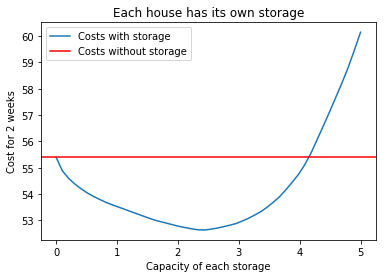

In [32]:
# Create grid with all and with one storage
g.change_storages(num_storages=data_cons.shape[1],max_capacity=0)
# connect each house to its own storage
for i in range(data_cons.shape[1]):
    g.change_storage_connection(num_house=i,storage_connection=i)
# Capacities to simulate
caps = np.linspace(0,5,50,dtype=float)
costs = np.array([])
for cap in caps:
    g.change_storages(num_storages=data_cons.shape[1],max_capacity=cap)
    for i in range(data_cons.shape[1]):
        g.change_storage_connection(num_house=i,storage_connection=i)
    costs = np.append(costs,objective_function(g.simulate(data_cons,data_prod)))
    
plt.plot(caps,costs,label='Costs with storage')
plt.axhline(cost_wo_storage,label='Costs without storage',c='r')
plt.xlabel('Capacity of each storage')
plt.ylabel('Cost for 2 weeks')
plt.legend()
plt.title('Each house has its own storage')

Now we observe the other boundary case in which we only have one storage. So there is maximum sharing, but also a maximum cost for connections to the storage.

Text(0.5, 1.0, 'Only a single storage')

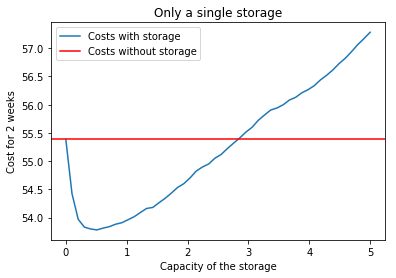

In [33]:
# Create grid with all and with one storage
g.change_storages(num_storages=1,max_capacity=0)
caps = np.linspace(0,5,50)
costs = np.array([])

for cap in caps:
    g.change_storages(num_storages=1,max_capacity=cap)
    costs = np.append(costs,objective_function(g.simulate(data_cons,data_prod)))
    
plt.plot(caps,costs,label='Costs with storage')
plt.xlabel('Capacity of the storage')
plt.ylabel('Cost for 2 weeks')
plt.axhline(cost_wo_storage,label='Costs without storage',c='r')
plt.legend()
plt.title('Only a single storage')